# CS 6053, Foundation of Data Science
## Predicting Asthma Hospitalizations Visits

In [1]:
# Mount google drive to import data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
import warnings
warnings.filterwarnings('ignore')

Import libraries

In [2]:
# Plotting and pandas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Models and sampling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost
from sklearn.utils import resample

# Metrics
from sklearn.metrics import mean_absolute_error,r2_score

# Warnings
import warnings
warnings.filterwarnings("ignore")

#### Fetching asthma data and setting column names.

In [3]:
export = pd.read_csv("/content/drive/My Drive/FDS/export.csv", encoding="utf-16",sep='\t')
asthma = export[["Ind1Name","Dim1Value","Dim2Value","Date ","Unnamed: 8"]]
asthma.columns = ['Indicator','Borough','Age Group','Date','Count']
asthma = asthma[asthma['Age Group']!='All age groups']

In [124]:
export.shape

(86835, 9)

#### Creating dummies for different age groups and renaming them.

In [4]:
asthma=pd.concat([asthma,pd.get_dummies(asthma['Age Group'])],axis=1)
asthma.rename(columns={'Ages 0-4 years': '0-4 years', 'Ages 18-64 years': '18-64 years', 'Ages 5-17 years': '5-17 years', 'Ages 65+ years': '65+ years'}, inplace=True)

#### Fetching pollutants data. Storing dataframe of every pollutant as value in dictionary for later merge.

In [5]:
years = ['2016','2017','2018','2019','2020']
pollutants = ['co','no','o3','pm25','so2']
airquality_data = {}
years = ['2016','2017','2018','2019','2020']
pollutants = ['co','no2','o3','pm25','so2']
for yr in years:
  for poll in pollutants:
    name = poll + '_' + yr[2:]
    airquality_data[name] = pd.read_csv("drive/My Drive/FDS/airquality_" + poll+ '_'+ yr+'.csv')

In [6]:
print(len(airquality_data))
airquality_data['co_16'].head(3)

25


,Date,Source,Site ID,POC,Daily Max 8-hour CO Concentration,UNITS,DAILY_AQI_VALUE,Site Name,DAILY_OBS_COUNT,PERCENT_COMPLETE,AQS_PARAMETER_CODE,AQS_PARAMETER_DESC,CBSA_CODE,CBSA_NAME,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
0,01/01/2016,AQS,360010012,1,0.3,ppm,3,LOUDONVILLE,19,79.0,42101,Carbon monoxide,10580,"Albany-Schenectady-Troy, NY",36,New York,1,Albany,42.68075,-73.75733
1,01/02/2016,AQS,360010012,1,0.3,ppm,3,LOUDONVILLE,24,100.0,42101,Carbon monoxide,10580,"Albany-Schenectady-Troy, NY",36,New York,1,Albany,42.68075,-73.75733
2,01/03/2016,AQS,360010012,1,0.3,ppm,3,LOUDONVILLE,24,100.0,42101,Carbon monoxide,10580,"Albany-Schenectady-Troy, NY",36,New York,1,Albany,42.68075,-73.75733


#### Processing pollutants data. Storing *processed* dataframe of every pollutant as value in dictionary for later merge.

##### For processing, we select pollutants data based on the counties and date. To later join with available data in asthma visits.

In [7]:
def aqi_data_proc(df,conc,aqi,obs):
  df.rename(columns={ df.columns[4]: conc, df.columns[6]:aqi,df.columns[8]:obs }, inplace = True)
  df = df[['Date', conc, aqi, obs, 'COUNTY']]
  countys = ['Bronx', 'New York', 'Suffolk', 'Queens']
  df = df[df['COUNTY'].isin(countys)] 
  df_new = pd.DataFrame(columns = df.columns)
  for d in df.Date.unique():
    for c in df.COUNTY.unique():
      df_new = df_new.append(df.loc[(df['Date'] == d) & (df["COUNTY"] == c)].head(1))

  return df_new
airquality_process = {}
years = ['2016','2017','2018','2019','2020']
pollutants = ['co','no2','o3','pm25','so2']
for yr in years:
  for poll in pollutants:
    key = poll + '_' + yr[2:]
    name = poll + '_' + yr
    airquality_process[name] = aqi_data_proc(airquality_data[key],poll+"_con",poll+"_aqi",poll+"_obs")

In [8]:
airquality_process['co_2019'].head()

,Date,co_con,co_aqi,co_obs,COUNTY
348,01/01/2019,0.4,5,19,Bronx
2158,01/01/2019,0.4,5,19,New York
2520,01/01/2019,0.3,3,19,Queens
349,01/02/2019,0.3,3,24,Bronx
2159,01/02/2019,0.5,6,24,New York


#### Merge all *processed* pollutant dataframes based on *years*.

##### Hence, for eg. no2 data for all years is combined first. i.e from 2016-2020

In [9]:
def merge_year(dfs):
  output_df = dfs[0]
  for df in dfs[1:]:
    output_df = output_df.append(df)
  return output_df
airquality_merge = {}
years = ['2016','2017','2018','2019','2020']
pollutants = ['co','no2','o3','pm25','so2']

for poll in pollutants:
  dataframes = [v for k,v in airquality_process.items() if poll in k]
  key = poll + '_' + 'combined'
  airquality_merge[key] = merge_year(dataframes)

#### Merge all combined pollutant dataframes.

##### Here, we finally get merged data for all pollutants, i.e. co,no2, etc.

In [10]:
df_aqi = airquality_merge['co_combined']
for to_merge in list(airquality_merge.keys())[1:]:
  df_aqi = pd.merge(df_aqi,airquality_merge[to_merge], on=['Date','COUNTY'],how='outer')

### **Preprocessing Data** 

#### Fill NA using ffill for pollutants data

In [11]:
df_fill = df_aqi.ffill(axis = 0)
df_fill['COUNTY'] = df_fill['COUNTY'].replace('New York','Brooklyn')
df_fill['COUNTY'] = df_fill['COUNTY'].replace('Suffolk','Manhattan')

In [12]:
df_fill.head(3)

,Date,co_con,co_aqi,co_obs,COUNTY,no2_con,no2_aqi,no2_obs,o3_con,o3_aqi,o3_obs,pm25_con,pm25_aqi,pm25_obs,so2_con,so2_aqi,so2_obs
0,01/01/2016,0.2,2,19,Bronx,17.7,16,24,0.024,22,17,8.3,35,1,0.9,0,24
1,01/01/2016,0.4,5,19,Brooklyn,17.7,16,24,0.025,23,17,0.0,0,1,0.9,0,24
2,01/01/2016,0.2,2,19,Queens,12.5,11,24,0.026,24,17,7.5,31,1,0.4,0,24


In [13]:
df_fill['COUNTY'].unique()

array(['Bronx', 'Brooklyn', 'Queens', 'Manhattan'], dtype=object)

#### Converting date time format as per asthma visits df and selecting data between available date range.

In [14]:
asthma['Date'] = pd.to_datetime(asthma['Date'], format='%m/%d/%y')
asthma_dep_visits = asthma[(asthma.Date > '31/12/15') & (asthma.Date < '1/1/21')]
asthma_dep_visits['Date'] = asthma_dep_visits['Date'].apply(lambda x: x.strftime('%m/%d/%Y'))

In [15]:
asthma_dep_visits.rename(columns={ asthma_dep_visits.columns[1]: 'COUNTY'}, inplace = True)

In [16]:
asthma_dep_visits

,Indicator,COUNTY,Age Group,Date,Count,0-4 years,18-64 years,5-17 years,65+ years
2481,Asthma,Bronx,Ages 0-4 years,01/01/2016,12.0,1,0,0,0
2482,Asthma,Bronx,Ages 0-4 years,01/02/2016,18.0,1,0,0,0
2483,Asthma,Bronx,Ages 0-4 years,01/03/2016,6.0,1,0,0,0
2484,Asthma,Bronx,Ages 0-4 years,01/04/2016,9.0,1,0,0,0
2485,Asthma,Bronx,Ages 0-4 years,01/05/2016,11.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
86169,Asthma,Citywide,Ages 65+ years,12/27/2020,13.0,0,0,0,1
86170,Asthma,Citywide,Ages 65+ years,12/28/2020,17.0,0,0,0,1
86171,Asthma,Citywide,Ages 65+ years,12/29/2020,27.0,0,0,0,1
86172,Asthma,Citywide,Ages 65+ years,12/30/2020,20.0,0,0,0,1


#### Merging **asthma visits** df and **pollutants data**

In [17]:
df_combined = pd.merge(df_fill, asthma_dep_visits, on=['Date','COUNTY'], how = 'inner')

In [18]:
df_combined.count()

Date           29120
co_con         29120
co_aqi         29120
co_obs         29120
COUNTY         29120
no2_con        29120
no2_aqi        29120
no2_obs        29120
o3_con         29120
o3_aqi         29120
o3_obs         29120
pm25_con       29120
pm25_aqi       29120
pm25_obs       29120
so2_con        29120
so2_aqi        29120
so2_obs        29120
Indicator      29120
Age Group      29120
Count          29120
0-4 years      29120
18-64 years    29120
5-17 years     29120
65+ years      29120
dtype: int64

#### Droping columns that are not required

In [19]:
df_combined.drop(['Indicator','Age Group' ,'Date', 'co_obs',
       'no2_obs','o3_obs',
       'pm25_obs', 'so2_obs','co_aqi','no2_aqi','so2_aqi','pm25_aqi','o3_aqi'],inplace=True,axis=1)
df_combined.head(10)

,co_con,COUNTY,no2_con,o3_con,pm25_con,so2_con,Count,0-4 years,18-64 years,5-17 years,65+ years
0,0.2,Bronx,17.7,0.024,8.3,0.9,12.0,1,0,0,0
1,0.2,Bronx,17.7,0.024,8.3,0.9,12.0,0,0,1,0
2,0.2,Bronx,17.7,0.024,8.3,0.9,33.0,0,1,0,0
3,0.2,Bronx,17.7,0.024,8.3,0.9,3.0,0,0,0,1
4,0.4,Brooklyn,17.7,0.025,0.0,0.9,6.0,1,0,0,0
5,0.4,Brooklyn,17.7,0.025,0.0,0.9,11.0,0,0,1,0
6,0.4,Brooklyn,17.7,0.025,0.0,0.9,50.0,0,1,0,0
7,0.4,Brooklyn,17.7,0.025,0.0,0.9,13.0,0,0,0,1
8,0.2,Queens,12.5,0.026,7.5,0.4,4.0,1,0,0,0
9,0.2,Queens,12.5,0.026,7.5,0.4,3.0,0,0,1,0


#### Encoding County column 

In [20]:
county = {'Bronx':0,'Brooklyn':1,'Queens':2,'Manhattan':3}
df_combined["COUNTY"] = df_combined["COUNTY"].apply(lambda x: county[x])

In [130]:
df_combined.shape

(29120, 11)

# Exploratory Data Analysis

#### Overall Distribution of CO concentration in the dataset

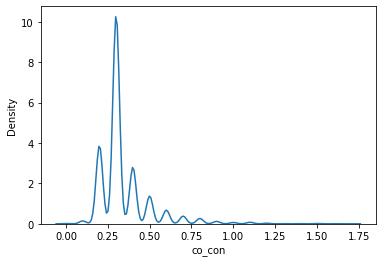

In [22]:
sns.distplot(df_combined['co_con'], hist = False,label='CO con Daily');

#### Overall Distribution of NO2 concentration in the dataset

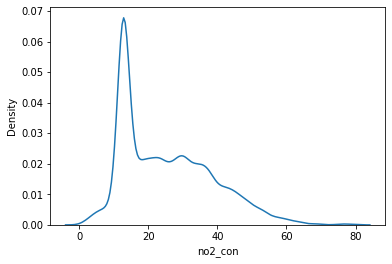

In [23]:
sns.distplot(df_combined['no2_con'], hist = False,label='NO2 con Daily');

#### Overall Distribution of O3 concentration in the dataset

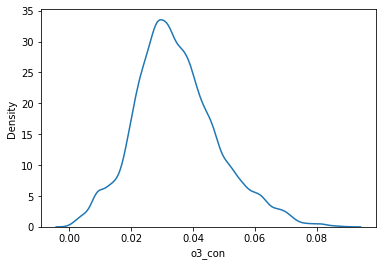

In [24]:
sns.distplot(df_combined['o3_con'], hist = False,label='O3 con Daily');

#### Overall Distribution of PM 2.5 concentration in the dataset

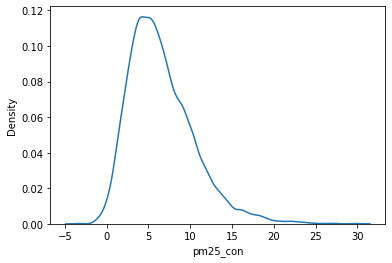

In [ ]:
sns.distplot(df_combined['pm25_con'], hist = False,label='PM2.5 con Daily');

#### Overall Distribution of SO2 concentration in the dataset

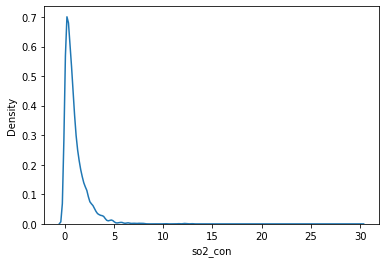

In [25]:
sns.distplot(df_combined['so2_con'], hist = False,label='SO2 Daily');

### Distribution of data: County vs Median pollutatnt concentration for that county

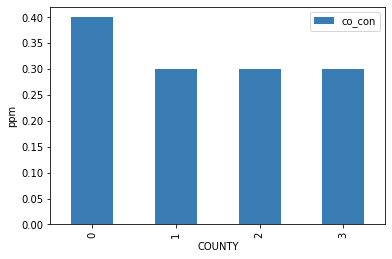

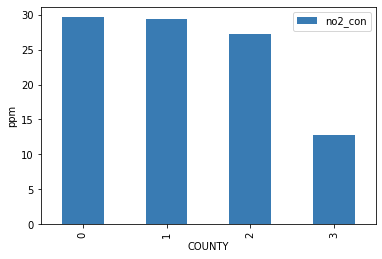

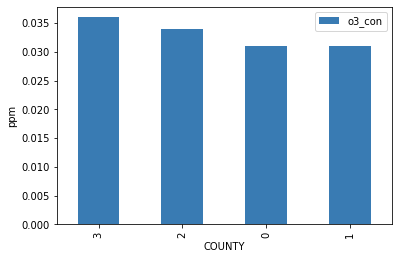

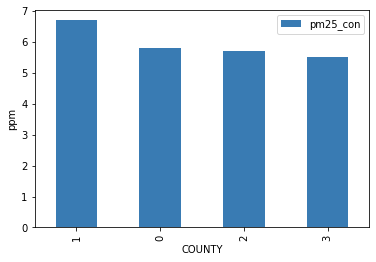

In [136]:
for poll in pollutants[:4]:
  pollutant = poll+'_con'
  df_combined[[pollutant,'COUNTY']].groupby(["COUNTY"]).median().sort_values(by=pollutant,ascending=False).plot.bar(ylabel="ppm", color='#397bb3')
  plt.show()

### Feature skewness of pollutants

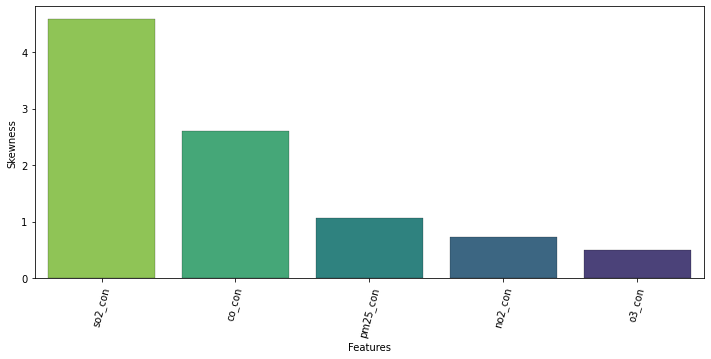

In [123]:
skew=pd.DataFrame(df_combined[['so2_con','co_con','pm25_con','no2_con','o3_con']].skew().sort_values(ascending=False))
skew.columns=['Skewness']

plt.figure(figsize=(12,5))
plt.xticks(rotation=75)
sns.barplot(x=skew.index,y='Skewness',data=skew,
            edgecolor='black',
            linewidth=0.2,
            palette='viridis_r')
plt.xlabel('Features');

### Feature corrrelation of pollutants

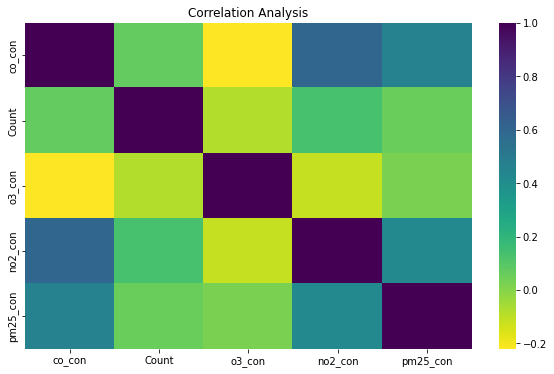

In [102]:
import numpy as np

df_pollutants = df_combined[['co_con','Count','o3_con','no2_con','pm25_con']]
plt.figure(figsize=(10,6))

mask=np.triu(df_pollutants.corr(method='pearson'))
sns.heatmap(df_pollutants.corr(),
            cmap='viridis_r')
plt.title('Correlation Analysis');

## Creating ML Models

#### Splitting Data using train test split

In [38]:
train = df_combined.drop(['Count'],axis=1)
test = df_combined['Count']
X_train, X_test, y_train, y_test = train_test_split(train,test,test_size=0.3, random_state=42)

### RandomForest Regressor

#### Using Grid Search CV to find best parameters for RandomForest Regressor

In [44]:
n_estimators = [5,7,10] # number of trees in the random forest
max_depth = [2,5,8] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 8] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True] # method used to sample data points

random_grid = {'n_estimators': n_estimators,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}

rf = RandomForestRegressor()

rf_random = GridSearchCV(estimator = rf,param_grid = random_grid,
                cv = 5, verbose=2, n_jobs = -1)
rf_random.fit(X_train, y_train)
print ('Random grid: ', random_grid, '\n')
# print the best parameters
print ('Best Parameters: ', rf_random.best_params_, ' \n')

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Random grid:  {'n_estimators': [5, 7, 10], 'max_depth': [2, 5, 8], 'min_samples_split': [2, 6, 8], 'min_samples_leaf': [1, 3, 4], 'bootstrap': [True]} 

Best Parameters:  {'bootstrap': True, 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 7}  



### Bootstraping data to train Random Forest Regressor model (with best parameters).

#### Here the metric for evaluation is mean absolute error.

In [147]:
# Defining number of iterations for bootstrap resample
n_iterations = 500

# Initializing estimator
rf_reg = RandomForestRegressor(bootstrap=True, max_depth=8, min_samples_leaf= 3, min_samples_split = 6,n_estimators =10)

# Initializing DataFrame, to hold bootstrapped statistics
bootstrapped_stats = pd.DataFrame()

# Each loop iteration is a single bootstrap resample and model fit
for i in range(n_iterations):

    # Sampling n_samples from data, with replacement, as train
    # Defining test to be all observations not in train
    train_df = resample(train, replace=True, n_samples=len(train))
    test_df = test

    X_train, X_test, y_train, y_test = train_test_split(train_df,test_df,test_size=0.3, random_state=42)
    # Fitting linear regression model
    rf_reg.fit(X_train, y_train)

    # Storing stats in DataFrame, and concatenating with stats
    prediction=rf_reg.predict(X_test)
    mae_score = mean_absolute_error(y_test,prediction)
    r_squared = rf_reg.score(X_test, y_test)

    bootstrapped_stats_i = pd.DataFrame(data=dict(
        mae = [mae_score],
        r_squared=[r_squared]
    ))

    bootstrapped_stats = pd.concat(objs=[bootstrapped_stats,
                                         bootstrapped_stats_i])

### Mean MAE Score for Random Forest for 500 iterations

In [148]:
print("MAE Score for Random Forest: ", np.mean(bootstrapped_stats["mae"]))

MAE Score for Random Forest:  12.422616616482385


### Plotting histogram for mean absolute error for 500 iterations.

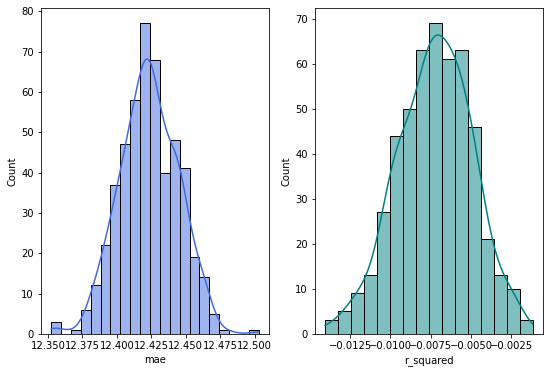

In [46]:
# Plotting histograms
fig, axes = plt.subplots(1, 2, figsize=(9, 6))
sns.histplot(bootstrapped_stats["mae"], color="royalblue", ax=axes[0], kde=True)
sns.histplot(bootstrapped_stats["r_squared"], color="teal", ax=axes[1], kde=True)

## Decision Tree Regression

#### Using Grid Search CV to find best parameters for Decision Tree Regressor

In [47]:
random_grid_tr = {"splitter":["best","random"],
            "max_depth" : [2,5,8],
           "min_samples_leaf":[1, 3, 4],
           "min_samples_split":[2, 6, 8],
           "max_leaf_nodes":[None,10,20],
            }

tree = DecisionTreeRegressor()

tree_random = GridSearchCV(estimator = tree,param_grid = random_grid_tr,
                cv = 5, verbose=2, n_jobs = -1)
tree_random.fit(X_train, y_train)
print ('Random grid: ', random_grid_tr, '\n')
# print the best parameters
print ('Best Parameters: ', tree_random.best_params_, ' \n')

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Random grid:  {'splitter': ['best', 'random'], 'max_depth': [2, 5, 8], 'min_samples_leaf': [1, 3, 4], 'min_samples_split': [2, 6, 8], 'max_leaf_nodes': [None, 10, 20]} 

Best Parameters:  {'max_depth': 2, 'max_leaf_nodes': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'random'}  



### Bootstraping data to train Decision Tree Regressor model (with best parameters).

#### Here the metric for evaluation is mean absolute error.

In [162]:
# Defining number of iterations for bootstrap resample
n_iterations = 500

# Initializing estimator
DTree = DecisionTreeRegressor(max_depth= 5, max_leaf_nodes= None, min_samples_leaf= 3, min_weight_fraction_leaf=0.3, splitter='random')

# Initializing DataFrame, to hold bootstrapped statistics
bootstrapped_stats = pd.DataFrame()

# Each loop iteration is a single bootstrap resample and model fit
for i in range(n_iterations):

    # Sampling n_samples from data, with replacement, as train
    # Defining test to be all observations not in train
    train_tree = resample(train, replace=True, n_samples=len(train))
    test_tree = test

    X_train, X_test, y_train, y_test = train_test_split(train_tree,test_tree,test_size=0.3, random_state=42)
    # Fitting linear regression model
    DTree.fit(X_train, y_train)

    # Storing stats in DataFrame, and concatenating with stats
    prediction=DTree.predict(X_test)
    mae_score = mean_absolute_error(y_test,prediction)
    r_squared = DTree.score(X_test, y_test)

    bootstrapped_stats_i = pd.DataFrame(data=dict(
        mae = [mae_score],
        r_squared=[r_squared]
    ))

    bootstrapped_stats = pd.concat(objs=[bootstrapped_stats,
                                         bootstrapped_stats_i])

### Mean MAE Score for Decision Tree for 500 iterations

In [163]:
print("Mean MAE Score for Decision Tree: ", np.mean(bootstrapped_stats["mae"]))

Mean MAE Score for Decision Tree:  12.391595687531334


### Plotting histogram for mean absolute error for 500 iterations.

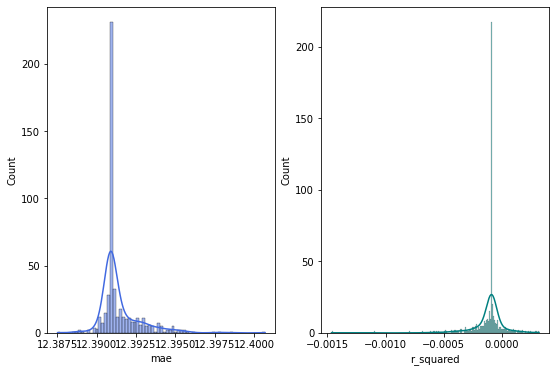

In [49]:
# Plotting histograms
fig, axes = plt.subplots(1, 2, figsize=(9, 6))
sns.histplot(bootstrapped_stats["mae"], color="royalblue", ax=axes[0], kde=True)
sns.histplot(bootstrapped_stats["r_squared"], color="teal", ax=axes[1], kde=True)

### XGBoost

#### Using Grid Search CV to find best parameters for XGBoost Regressor

In [50]:
random_grid_xg = {
    'clf__n_estimators': [5,7,10],
    'clf__learning_rate': [0.01, 0.1, 0.2],
    'clf__max_depth': [2,5,8],
    'clf__colsample_bytree': [i/10.0 for i in range(1, 3)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__k': [10],
  
            }

xg = xgboost.XGBRegressor()

xg_random = GridSearchCV(estimator = xg,param_grid = random_grid_xg,
                cv = 5, verbose=2, n_jobs = -1)
xg_random.fit(X_train, y_train)
print ('Random grid: ', random_grid_xg, '\n')
# print the best parameters
print ('Best Parameters: ', xg_random.best_params_, ' \n')

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[22:42:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Random grid:  {'clf__n_estimators': [5, 7, 10], 'clf__learning_rate': [0.01, 0.1, 0.2], 'clf__max_depth': [2, 5, 8], 'clf__colsample_bytree': [0.1, 0.2], 'clf__gamma': [0.0, 0.1, 0.2], 'fs__k': [10]} 

Best Parameters:  {'clf__colsample_bytree': 0.1, 'clf__gamma': 0.0, 'clf__learning_rate': 0.01, 'clf__max_depth': 2, 'clf__n_estimators': 5, 'fs__k': 10}  



### Bootstraping data to train XGBoost Regressor model (with best parameters).
#### Here the metric for evaluation is mean absolute error.

In [157]:
# Defining number of iterations for bootstrap resample
n_iterations = 500

# Initializing estimator
xg_reg = xgboost.XGBRegressor(max_depth= 5, max_leaf_nodes= None, min_samples_leaf= 3, min_weight_fraction_leaf=0.3, splitter='random')

# Initializing DataFrame, to hold bootstrapped statistics
bootstrapped_stats = pd.DataFrame()

# Each loop iteration is a single bootstrap resample and model fit
for i in range(n_iterations):

    # Sampling n_samples from data, with replacement, as train
    # Defining test to be all observations not in train
    train_xg = resample(train, replace=True, n_samples=len(train))
    test_xg = test

    X_train, X_test, y_train, y_test = train_test_split(train_xg,test_xg,test_size=0.3, random_state=42)
    # Fitting linear regression model
    xg_reg.fit(X_train, y_train)

    # Storing stats in DataFrame, and concatenating with stats
    prediction=DTree.predict(X_test)
    mae_score = mean_absolute_error(y_test,prediction)
    r_squared = xg_reg.score(X_test, y_test)

    bootstrapped_stats_i = pd.DataFrame(data=dict(
        mae = [mae_score],
        r_squared=[r_squared]
    ))

    bootstrapped_stats = pd.concat(objs=[bootstrapped_stats,
                                         bootstrapped_stats_i])

[04:32:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:32:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:32:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:32:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:32:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:32:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:32:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:32:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

### Mean MAE Score for XGBoost for 500 iterations

In [160]:
print("mean mae Score for XGBoost: ", np.mean(bootstrapped_stats["mae"]))

mean mae Score for XGBoost:  12.392307548826176


### Plotting histogram for mean absolute error for 500 iterations.

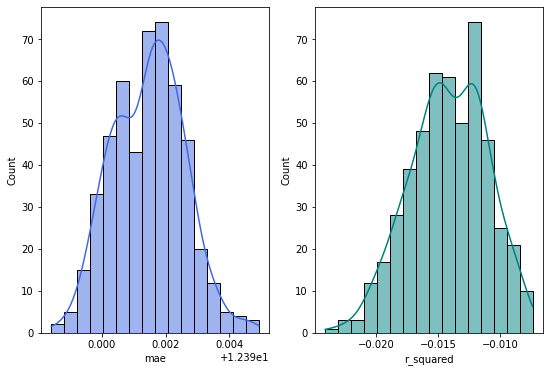

In [52]:
# Plotting histograms
fig, axes = plt.subplots(1, 2, figsize=(9, 6))
sns.histplot(bootstrapped_stats["mae"], color="royalblue", ax=axes[0], kde=True)
sns.histplot(bootstrapped_stats["r_squared"], color="teal", ax=axes[1], kde=True)

### Feature importance

### Random Forest Feature Importance

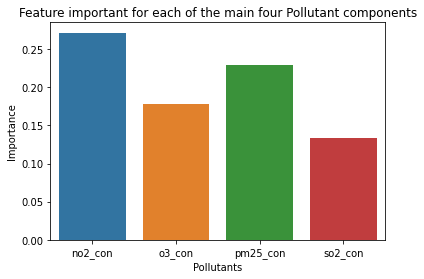

In [137]:
sns.barplot(y=rf_reg.feature_importances_[2:6], x=X_train.columns[2:6]); 
plt.title('Feature important for each of the main four Pollutant components')
plt.xlabel('Pollutants')
plt.ylabel('Importance')
plt.show()

### XgBoost Feature Importance

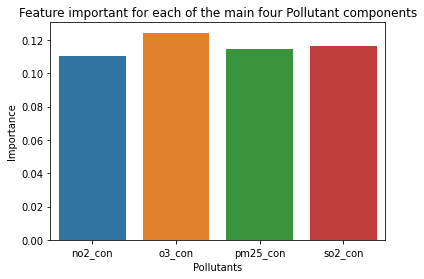

In [138]:
sns.barplot(y=xg_reg.feature_importances_[2:6], x=X_train.columns[2:6])
plt.title('Feature important for each of the main four Pollutant components')
plt.xlabel('Pollutants')
plt.ylabel('Importance')
plt.show()